# Deep Learning
### Week 8: Normalising flows I: Autoregressive flows

## Contents

[1. Introduction](#introduction)

[2. Change of variables formula](#changeofvariables)

[3. Distributions (\*)](#distributions)

[4. Bijectors (\*)](#bijectors)

[5. Autoregressive flows](#arflows)

[6. Masked autoregressive flow (MAF) (\*)](#maf)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

So far in this module we have covered many of the fundamental building blocks of deep learning: from mathematical neurons and multilayer perceptrons, to optimisation and regularisation of deep learning models, and important architectures such as convolutional and recurrent neural networks.

In the remaining weeks of the module, we will use these building blocks to focus our attention on the probabilistic approach to deep learning. This is a branch of deep learning that aims to make use of tools from probability theory to account for noise and uncertainty in the data. Probabilistic deep learning models make direct use of probability distributions and latent random variables in the model architecture.

In this week of the course we will begin to familiarise ourselves with the [TensorFlow Probability](https://www.tensorflow.org/probability/) (TFP) library, which is built on TensorFlow to enable a closer integration between deep learning, probabilistic modelling and statistical analysis. In particular, we will learn about `Distribution` and `Bijector` objects in TFP.

These objects will provide the tools we need to develop normalising flow deep learning models. Normalising flows are a class of generative models, that were first popularised in the context of variational inference by [Rezende & Mohamed 2015](#Rezende15), and in the context of density estimation by [Dinh et al 2015](#Dinh15). In this week, we will focus on using normalising flows to estimate continuous data distributions.

When trained as a density estimator, this type of model is able to produce new instances that could plausibly have come from the same dataset that it is trained on, as well as tell you whether a given example instance is likely. However, for complex datasets the data distribution can be very difficult to model, so this is a highly nontrivial task in general. This is where the power of deep learning models can be leveraged to learn highly multimodal and complicated data distributions, and this type of model has been successfully applied to domains such as image generation ([Ho et al 2019](#Ho19)), noise modelling ([Abdelhamed et al 2019](#Abdelhamed19)), audio synthesis ([Prenger et al 2019](#Prenger19)), and video generation ([Kumar et al 2019](#Kumar19)).

In this week, we will see how to construct autoregressive normalising flow architectures, including the masked autoregressive flow ([Papamakarios et al 2017](#Papamakarios17)).

<a class="anchor" id="changeofvariables"></a>
## Change of variables formula

The approach taken by normalising flows to solve the density estimation task is to take an initial, simple density, and transform it - possibly using a series of parameterised transformations - to produce a rich and complex distribution. 

If these transformations are smooth and invertible, then we are able to evaluate the density of the complex transformed distribution. This property is important, because it then allows to train such a model using maximum likelihood. This is the idea behind normalising flows. The invertible transformations themselves are what constitute the bijectors module in the Tensorflow Probability library.

We'll start this week by reviewing the change of variables formula, which forms the mathematical basis of normalising flows.

#### Statement of the formula
Let $Z := (z_1,\ldots,z_D)\in\mathbb{R}^D$ be a $D$-dimensional continuous random variable, and suppose that $f:\mathbb{R}^D\mapsto\mathbb{R}^D$ is a smooth, invertible transformation. Now consider the change of variables $X = f(Z)$, with $X=(x_1,\ldots,x_D)$, and denote the probability density functions of the random variables $Z$ and $X$ by $p_Z$ and $p_X$ respectively.

The change of variables formula states that

$$
p_X(\mathbf{x}) = p_Z(\mathbf{z})\cdot\left|\det J_f(\mathbf{z}) \right|^{-1},\tag{1}
$$

where $\mathbf{x}, \mathbf{z}\in\mathbb{R}^D$, and $J_f(\mathbf{z})\in\mathbb{R}^{D\times D}$ is the **Jacobian** of the transformation $f$, given by the matrix of partial derivatives

$$
J_f(\mathbf{z}) = \left[ 
\begin{array}{ccc}
\frac{\partial f_1}{\partial z_1}(\mathbf{z}) & \cdots & \frac{\partial f_1}{\partial z_D}(\mathbf{z})\\
\vdots & \ddots & \vdots\\
\frac{\partial f_D}{\partial z_1}(\mathbf{z}) & \cdots & \frac{\partial f_D}{\partial z_d}(\mathbf{z})\\
\end{array}
\right],
$$

and $\left|\det J_f(\mathbf{z}) \right|$ is the absolute value of the determinant of the Jacobian matrix. Note that (1) can also be written in the log-form

$$
\log p_X(\mathbf{x}) = \log p_Z(\mathbf{z}) - \log \hspace{0.1ex}\left|\det J_f(\mathbf{z}) \right|. \tag{2}
$$

Furthermore, we can equivalently consider the transformation $Z = f^{-1}(X)$. Then the change of variables formulae can be written as

$$
\begin{align}
p_Z(\mathbf{z}) &= p_X(\mathbf{x})\cdot\left|\det J_{f^{-1}}(\mathbf{x}) \right|^{-1},\tag{3}\\
\log p_Z(\mathbf{z}) &= \log p_X(\mathbf{x}) - \log \hspace{0.1ex}\left|\det J_{f^{-1}}(\mathbf{x}) \right|.\tag{4}
\end{align}
$$

#### A simple example
We will demonstrate the change of variables formula with a simple example. Let $Z=(z_1, z_2)$ be a 2-dimensional random variable that is uniformly distributed on the unit square $[0, 1]^2 =: \Omega_Z$. We also define the transformation $f:\mathbb{R}^2 \mapsto \mathbb{R}^2$ as

$$
\begin{align}
f(z_1, z_2) = (\lambda z_1, \mu z_2)
\end{align}
$$

for some nonzero $\lambda, \mu\in\mathbb{R}$. The random variable $X=(x_1, x_2)$ is given by $X = f(Z)$. 

<img src="figures/change_of_variables.pdf" alt="Change of variables example in 2D" style="width: 750px;"/>
<center>Linearly transformed uniformly distributed random variable</center>

Since $\int_{\Omega_Z}p_Z(\mathbf{z})d\mathbf{z} = 1$ and $\mathbf{z}$ is uniformly distributed, we have that 

$$
p_Z(\mathbf{z}) = 1 \quad\text{for}\quad \mathbf{z}\in\Omega_Z.
$$

The random variable $X$ is uniformly distributed on the region $\Omega_X = f(\Omega_Z)$ as shown in the figure above (for the case $\lambda, \mu>0$). Since again $\int_{\Omega_X}p_X(\mathbf{x})d\mathbf{x} = 1$, the probability density function for $X$ must be given by 

$$
p_X(\mathbf{x}) = \frac{1}{|\Omega_X|} = \frac{1}{|\lambda\mu |}\quad\text{for}\quad \mathbf{x}\in\Omega_X.
$$

This result corresponds to the equations \eqref{cov_f}-\eqref{logcov_finv} above. In this simple example, the transformation $f$ is linear, and the Jacobian matrix is given by

$$
\begin{align}
J_f(\mathbf{z}) = \left[
\begin{array}{cc}
\lambda & 0\\
0 & \mu
\end{array}
\right].
\end{align}
$$

The absolute value of the determinant is $\left|\det J_{f^{-1}}(\mathbf{x}) \right| = |\lambda\mu | \ne 0$. Equation \eqref{cov_f} then implies

$$
\begin{align}
p_X(\mathbf{x}) &= p_Z(\mathbf{z})\cdot\left|\det J_f(\mathbf{z}) \right|^{-1}\\
&= \frac{1}{|\lambda\mu|}.
\end{align}
$$

Writing in the log-form as in equation \eqref{logcov_f} gives

$$
\begin{align}
\log p_X(\mathbf{x}) &= \log p_Z(\mathbf{z}) - \log \hspace{0.1ex}\left|\det J_f(\mathbf{z}) \right|\\
&= \log (1) - \log |\lambda\mu|\\
&= - \log |\lambda\mu|.
\end{align}
$$

#### Sketch of proof in 1-D
We now provide a sketch of the proof of the change of variables formula in one dimension. Let $Z$ and $X$ be random variables such that $X = f(Z)$, where $f : \mathbb{R}\mapsto\mathbb{R}$ is a $C^k$ diffeomorphism with $k\ge 1$. The change of variables formula in one dimension can be written

$$
p_X(x) = p_Z(z)\cdot\left| \frac{d}{dz}f(z) \right|^{-1},\qquad\text{(cf. equation )}
$$

or equivalently as

$$
p_X(x) = p_Z(z)\cdot\left| \frac{d}{dx}f^{-1}(x) \right|.\qquad\text{(cf. equation)}
$$

_Sketch of proof._ For $f$ to be invertible, it must be strictly monotonic. That means that for all $x^{(1)}, x^{(2)}\in\mathbb{R}$ with $x^{(1)} < x^{(2)}$, we have $f(x^{(1)}) < f(x^{(2)})$ (strictly monotonically increasing) or $f(x^{(1)}) > f(x^{(2)})$ (strictly monotonically decreasing).

<img src="figures/change_of_variables_monotonic.pdf" alt="Monotonic functions" style="width: 600px;"/>
<center>Sketch of monotonic functions: (a) strictly increasing, (b) strictly decreasing</center>

Suppose first that $f$ is strictly increasing. Also let $F_X$ and $F_Z$ be the cumulative distribution functions of the random variables $X$ and $Z$ respectively. Then we have

$$
\begin{align}
F_X(x) &= P(X \le x)\\
&= P(f(Z) \le x)\\
&= P(Z \le f^{-1}(x))\qquad\text{(since $f$ is monotonically increasing)}\\
&= F_Z(f^{-1}(x))
\end{align}
$$

By differentiating on both sides with respect to $x$, we obtain the probability density function:

$$
\begin{align}
p_X(x) &= \frac{d}{dx}F_X(x)\\
&= \frac{d}{dx} F_Z(f^{-1}(x))\\
&= \frac{d}{dz}F_Z(z)\cdot\frac{d}{dx}f^{-1}(x)\\
&= p_Z(z)\frac{d}{dx}f^{-1}(x) \tag{5}
\end{align}
$$

Now suppose first that $f$ is strictly decreasing. Then

$$
\begin{align}
F_X(x) &= P(X \le x)\\
&= P(f(Z) \le x)\\
&= P(Z \ge f^{-1}(x))\qquad\text{(since $f$ is monotonically decreasing)}\\
&= 1 - F_Z(f^{-1}(x))
\end{align}
$$

Again differentiating on both sides with respect to $x$:

$$
\begin{align}
p_X(x) &= \frac{d}{dx}F_X(x)\\
&= -\frac{d}{dx} F_Z(f^{-1}(x))\\
&= -F_Z'(f^{-1}(x))\frac{d}{dx}f^{-1}(x)\\
&= -p_Z(z)\frac{d}{dx}f^{-1}(x) \tag{6}
\end{align}
$$

Now note that the inverse of a strictly monotonically increasing (resp. decreasing) function is again strictly monotonically increasing (resp. decreasing). This implies that the quantity $\frac{d}{dx} f^{-1}(x)$ is positive in \eqref{pdfx_inc} and negative in \eqref{pdfx_dec}, and so these two equations can be combined into the single equation:

$$
p_X(x) = p_Z(z)\left|\frac{d}{dx}f^{-1}(x)\right|
$$

which completes the proof.

#### Application to normalising flows
Normalising flows are a class of models that exploit the change of variables formula to estimate an unknown target data density. 

Suppose we have data samples $\mathcal{D}:=\{\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(n)}\}$, with each $\mathbf{x}^{(i)}\in\mathbb{R}^D$, and assume that these samples are generated i.i.d. from the underlying distribution $p_X$. 

A normalising flow models the distribution $p_X$ using a random variable $Z$ (also of dimension $D$) with a simple distribution $p_Z$ (e.g. an isotropic Gaussian), such that the random variable $X$ can be written as a change of variables $X = f_\theta(Z)$, where $\theta$ is a parameter vector that parameterises the smooth invertible function $f_\theta$. 

The function $f_\theta$ is modelled using a neural network with parameters $\theta$, which we want to learn from the data. An important point is that this neural network must be designed to be invertible, which is not the case in general with deep learning models. In practice, we often construct the neural network by composing multiple simpler blocks together. In TensorFlow Probability, these simpler blocks are the _bijectors_ that we will study in the first part of the week.

We use the principle of maximum likelihood to learn the optimal parameters $\theta$; that is:

$$
\begin{align}
\theta_{ML} &:= \arg \max_{\theta} P(\mathcal{D}; \theta)\\
&= \arg \max_{\theta} \log P(\mathcal{D}; \theta).
\end{align}
$$

In order to compute $\log P(\mathcal{D}; \theta)$ we can use the change of variables formula:

$$
\begin{align}
P(\mathcal{D}; \theta) &= \prod_{\mathbf{x}\in\mathcal{D}}  p_Z(f_\theta^{-1}(\mathbf{x})) \cdot\left|\hspace{0.1ex}\det J_{f_\theta^{-1}}(\mathbf{x}) \hspace{0.1ex}\right|\\
\log P(\mathcal{D}; \theta) &= \sum_{x\in\mathcal{D}} \log p_Z(f_\theta^{-1}(\mathbf{x})) + \log \hspace{0.1ex}\left|\hspace{0.1ex}\det J_{f_\theta^{-1}}(\mathbf{x}) \hspace{0.1ex}\right|\tag{7}
\end{align}
$$

The term $p_Z(f_\theta^{-1}(\mathbf{x}))$ can be computed for a given data point $\mathbf{x}\in\mathcal{D}$ since the neural network $f_\theta$ is designed to be invertible, and the distribution $p_Z$ is known. The term $\det J_{f_\theta^{-1}}(\mathbf{x})$ is also computable, although this also highlights another important aspect of normalising flow models: they should be designed such that the determinant of the Jacobian can be efficiently computed.

The log-likelihood \eqref{logliknf} is usually optimised as usual in minibatches, with gradient-based optimisation methods.

<a class="anchor" id="distributions"></a>
## Distributions

In this section we will look at `Distribution` objects in TensorFlow Probability, which are naturally one of the fundamental building blocks of the library. The main operations that we'll be using are sampling, and computing log-probabilities. 

A key point in understanding the interface and behaviour of these objects is that they are designed to perform vectorised computations for efficiency. This means that single objects are able to handle batches of distributions, samples, and log-probability computations. We'll see that this means we have to think quite carefully about the shapes of Tensors that we're using, and what these shapes mean. 

In [2]:
import tensorflow as tf

We will use the following namespace for the TensorFlow Probability library.

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions

#### Univariate distributions
We will first create some univariate distributions. There is a wide range of distributions available in the [distributions module](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions), of which we will only be using a few.

In [4]:
# Create a univariate Normal distribution

normal = tfd.Normal(loc = 0., scale = 1.)
normal
#scalar event shape as univariate

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [5]:
# Sample from the distribution

normal.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=0.93950576>

In [6]:
# Draw multiple samples

normal.sample(5)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.10361869,  1.380178  , -0.03275524,  0.26111993,  0.58884495],
      dtype=float32)>

In [7]:
# We can pass a shape to the sample method

normal.sample((2,3))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 0.64348453,  0.6433284 ,  0.3100489 ],
       [-1.6788237 , -1.392221  , -1.4411781 ]], dtype=float32)>

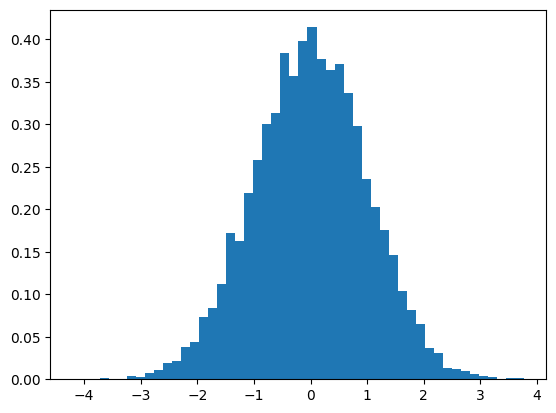

In [8]:
# Plot some samples
import matplotlib.pyplot as plt

z = normal.sample(10000).numpy()
plt.hist(z, bins = 50, density = True)
plt.show()


In [9]:
# Compute prob / log-prob of test points

#this gives the density at the point
normal.prob(0)
#this gives log density
normal.log_prob(0)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [10]:
# Compute prob / log-prob of a batch of test points
test_pts = tf.random.normal((3,2))
normal.log_prob(test_pts)


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-1.9851055 , -0.92110556],
       [-0.9537993 , -2.259463  ],
       [-0.9761788 , -2.3440151 ]], dtype=float32)>

A single `Distribution` object can represent a batch of distributions of the same type:

In [11]:
# Create an exponential distribution

exp = tfd.Exponential(rate = 1)
exp

<tfp.distributions.Exponential 'Exponential' batch_shape=[] event_shape=[] dtype=float32>

In [12]:
# Create a batched exponential distribution

batch_exp = tfd.Exponential(rate = [0.5,1,1.5])
batch_exp
#now batch shape is 3

<tfp.distributions.Exponential 'Exponential' batch_shape=[3] event_shape=[] dtype=float32>

In [13]:
# Sample from the distribution
batch_exp.sample((2,1))
#always of the shape sample shape followed by batch shape



<tf.Tensor: shape=(2, 1, 3), dtype=float32, numpy=
array([[[3.820577  , 0.85722136, 0.4240806 ]],

       [[2.312252  , 0.08734856, 0.9159932 ]]], dtype=float32)>

We can see a first use of broadcasting when computing log-probabilities with a batched distribution.

In [14]:
# Compute log-probs
test_pts = tf.random.uniform(())
#broadcasted against batch size
print(batch_exp.log_prob(test_pts))

test_pts = tf.random.uniform((4,1))
#broadcasted against batch size
print(batch_exp.log_prob(test_pts))
#(4,) would not work


tf.Tensor([-1.137742   -0.88918936 -0.92831874], shape=(3,), dtype=float32)
tf.Tensor(
[[-1.1680286  -0.9497622  -1.0191779 ]
 [-0.79791003 -0.20952523  0.09117752]
 [-0.98645985 -0.58662486 -0.47447193]
 [-1.1088054  -0.8313161  -0.84150887]], shape=(4, 3), dtype=float32)


#### Multivariate distributions
In the distributions seen so far, the `event_shape` property has been empty, indicating that the distribution is univariate. Here, we look at multivariate distributions.

In [15]:
# Create a multivariate Gaussian distribution

mvn = tfd.MultivariateNormalDiag(loc = [0,3], scale_diag = [1,5])
mvn

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [16]:
# Sample from the distribution
mvn.sample(3)
#3 samples from 2d event


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1.8391994 ,  4.631362  ],
       [-0.09325986,  7.7660246 ],
       [-0.58958787,  1.3235116 ]], dtype=float32)>

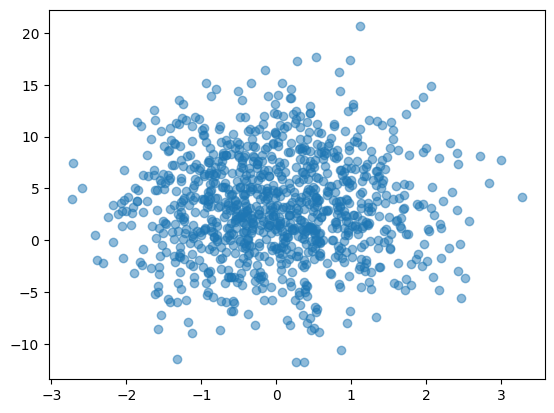

In [17]:
# Plot samples from the multivariate Gaussian
samples = mvn.sample(1000)
plt.scatter(samples[:,0], samples[:,1], alpha = 0.5)
plt.show()


In [18]:
# Compute log-probs

test_pts = tf.random.normal((2,))
print(mvn.log_prob(test_pts))
#makes sense we get this since we passed in length 2 tensor and mvn is 2d

#this would broadcast the 1 to 2
test_pts = tf.random.normal((5,1))
print(mvn.log_prob(test_pts))
#makes sense we get this since we passed in length 2 tensor and mvn is 2d

test_pts = tf.random.normal((3,2))
mvn.log_prob(test_pts)
#we get instances of 2d so 3 output

tf.Tensor(-3.9482439, shape=(), dtype=float32)
tf.Tensor([-5.3046136 -4.455199  -4.006646  -3.6271107 -3.7317812], shape=(5,), dtype=float32)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-3.9395938, -4.9308333, -3.5314965], dtype=float32)>

We can also create a multivariate Gaussian using [`MultivariateNormalTriL`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalTriL), by passing in the lower triangular matrix $L$ such that $LL^T = \Sigma$, where $\Sigma$ is the covariance matrix. This is the Cholesky decomposition (see also [`tf.linalg.cholesky`](https://www.tensorflow.org/api_docs/python/tf/linalg/cholesky)).

In [19]:
# Construct a multivariate Gaussian with MultivariateNormalTriL

mu = [0.,0.]
scale_tril = [[1.,0.,],
              [0.6,0.8]]

mvn2 = tfd.MultivariateNormalTriL(loc = mu, scale_tril=scale_tril)
mvn2

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[2] dtype=float32>

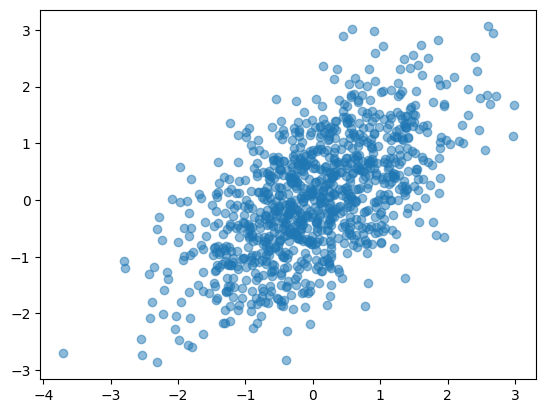

In [20]:
# Plot samples from the multivariate Gaussian

# Plot samples from the multivariate Gaussian
samples = mvn2.sample(1000)
plt.scatter(samples[:,0], samples[:,1], alpha = 0.5)
plt.show()


There are further ways of constructing a multivariate Gaussian: see the docs for [`MultivariateNormalDiagPlusLowRank`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalDiagPlusLowRank), [`MultivariateNormalFullCovariance`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalFullCovariance) and [`MultivariateNormalLinearOperator`](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/MultivariateNormalLinearOperator).

Multivariate distributions can also be batched together, as in the following example.

In [21]:
# Create a batched multivariate Gaussian

#pass batch of means and covs
#single diag is broadcasted to both members of the batch (batch of parameters)
batched_mvn = tfd.MultivariateNormalDiag(loc = [[0.,-1,-0.5], [1.,0.5,0.]], scale_diag = [0.5,1.5,1.])
batched_mvn

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[2] event_shape=[3] dtype=float32>

In [22]:
# The batch and event shape are properties of the distribution

batched_mvn.batch_shape
batched_mvn.event_shape

TensorShape([3])

Of course we can also sample from a batched, multivariate distribution. The following shows the ordering of shapes that we should always keep in mind when working with `Distribution` objects:

`(sample_shape, batch_shape, event_shape)`

In [23]:
# Sample from the batched multivariate Gaussian
batched_mvn.sample(4)

batched_mvn.sample((4,2))

#ORDER IS ALWAYS SAMPLE_SHAPE X (PARAMETER) BATCH SIZE X EVENT_SIZE (DIMENSION)

#note that we think of BATCH SIZE as for the parameters, but can still do the sample shape as a batch

<tf.Tensor: shape=(4, 2, 2, 3), dtype=float32, numpy=
array([[[[ 5.8038127e-01, -1.8598292e+00, -9.6878755e-01],
         [ 1.7465680e+00,  1.2862110e+00,  1.1566725e+00]],

        [[ 4.6039829e-01,  8.3256650e-01, -2.7154179e+00],
         [ 1.5778036e+00,  1.2605957e+00, -3.5394010e-01]]],


       [[[ 3.0178316e-03, -6.6764110e-01, -1.5931230e+00],
         [ 1.2563883e+00,  6.6873598e-01, -1.6233103e-01]],

        [[-2.5402057e-01, -1.8467901e+00, -3.6691731e-01],
         [ 1.1550739e+00,  3.7807548e-01,  1.6609763e-01]]],


       [[[-3.5604396e-01, -2.8250089e+00,  6.8408251e-01],
         [ 9.9293846e-01, -6.9303441e-01,  3.0568943e+00]],

        [[-2.3227994e-01,  4.0561688e-01, -9.8140746e-01],
         [ 1.8238187e-01, -6.8045866e-01,  1.2466105e+00]]],


       [[[-4.7757915e-01, -2.2301865e+00,  7.4560940e-01],
         [ 2.0879638e-01,  8.9529818e-01, -5.5040121e-01]],

        [[-9.3319958e-01, -2.6874413e+00,  1.0625851e+00],
         [ 9.1262656e-01, -7.7467585e-01,

_Exercise._ Take a look at the following Distribution object and call to the `log_prob` method. Work out what the shape of the resulting Tensor will be before you run the cell.

In [24]:
mvn3 = tfd.MultivariateNormalDiag(loc=[[[2., 0., 0.5], [1., -0.5, 2.]]], scale_diag=[0.5, 1., 1.5])
#event size is 3, batch is 1x2
print(mvn3)
test_pts = tf.random.normal((5, 1, 2, 1))
#5 is number of test points in each batch, each with batch size (1,2), which is then casted to have 3 event size
mvn3.log_prob(test_pts)



tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[1, 2], event_shape=[3], dtype=float32)


<tf.Tensor: shape=(5, 1, 2), dtype=float32, numpy=
array([[[ -4.43938  ,  -4.694224 ]],

       [[-10.529362 , -19.941397 ]],

       [[-10.005936 ,  -4.889048 ]],

       [[ -5.4591384, -12.886442 ]],

       [[ -5.9449396,  -5.3171268]]], dtype=float32)>

#### Independent distribution
The `Independent` distribution is often useful to manipulate batch and event shapes, and define multivariate distributions from univariate objects.

In [25]:
# Create a batched Bernoulli distribution

bernoulli = tfd.Bernoulli(probs = [[0.1,0.3,0.5], [0.4,0.8,0.7]])
bernoulli
#batch shape of [2,3]

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[2, 3] event_shape=[] dtype=int32>

In [26]:
# Transfer the second batch dimension into the event space

ind_bernoulli = tfd.Independent(bernoulli, reinterpreted_batch_ndims = 1)
ind_bernoulli
#now the final batch has been transferred into the event space
#now it is a batch of 2 distributions each operating on a 3d event space, and each variable within the event space is independently distributed 

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[2] event_shape=[3] dtype=int32>

In [27]:
# Compute log-probs on both distributions

import numpy as np
test_pts = np.random.choice([0,1],(2,3))
print(test_pts)
print(bernoulli.log_prob(test_pts))
#we get each bernoulli distribution in the batch evaluating log probs on each event in the batch, which is of shape [2,3]
print(ind_bernoulli.log_prob(test_pts))
#for the independent bernoulli object, we get length 2, since this distribution operates on events of size 3, so returns single value for each element in batch of size 2

#since it is indep, values in second tensor are sums of rows in first

[[0 1 1]
 [1 1 1]]
tf.Tensor(
[[-0.10536052 -1.2039728  -0.6931472 ]
 [-0.9162907  -0.22314353 -0.35667497]], shape=(2, 3), dtype=float32)
tf.Tensor([-2.0024805 -1.4961092], shape=(2,), dtype=float32)


In [28]:
# Transfer all batch dimensions into the event space

ind_bernoulli = tfd.Independent(bernoulli, reinterpreted_batch_ndims = 2)
ind_bernoulli

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[] event_shape=[2, 3] dtype=int32>

In [29]:
# Compute log-probs with the new distribution

print(ind_bernoulli.log_prob(test_pts))
#scalar since test points is now a single event

tf.Tensor(-3.4985898, shape=(), dtype=float32)


_Exercise._ Construct a distribution object over a three-dimensional event space $(X_1, X_2, X_3)$, where each $X_i$ are independently distributed according to a Bernoulli distribution where the probability of a 0 event is equal to 0.9, 0.7 and 0.5 respectively. Use your distribution object to show that the log probability of the event $P(X_1, X_2, X_3) = (1, 1, 1)$ is equal to -4.199705.

In [30]:
exercise_b = tfd.Bernoulli(probs = [0.1,0.3,0.5])
exercise_b_indep = tfd.Independent(exercise_b, reinterpreted_batch_ndims = 1)
test = tf.ones((3))
exercise_b_indep.log_prob(test)


<tf.Tensor: shape=(), dtype=float32, numpy=-4.199705>

<a class="anchor" id="bijectors"></a>
## Bijectors

In this section we will look at bijectors, which are another fundamental building block in TensorFlow Probability. Bijectors constitute the invertible and differentiable transformations that we will use to construct normalising flows. The [bijectors module](https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors) has a range of in-built bijector functions, which can be composed to make complex transformations.

In [31]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

Two simple bijectors are the `Scale` and `Shift` bijectors.

In [32]:
# Create Scale and Shift bijectors

scale = tfb.Scale(3.0)
shift = tfb.Shift(-5)

In [33]:
# Draw samples from a standard Normal distribution

normal = tfd.Normal(0,1)
z = normal.sample(1000)
z.shape

TensorShape([1000])

In [34]:
# Pass the samples through the forward method of each bijector
h = scale.forward(z)
x = shift.forward(h)
#dont need forward
x.shape


TensorShape([1000])

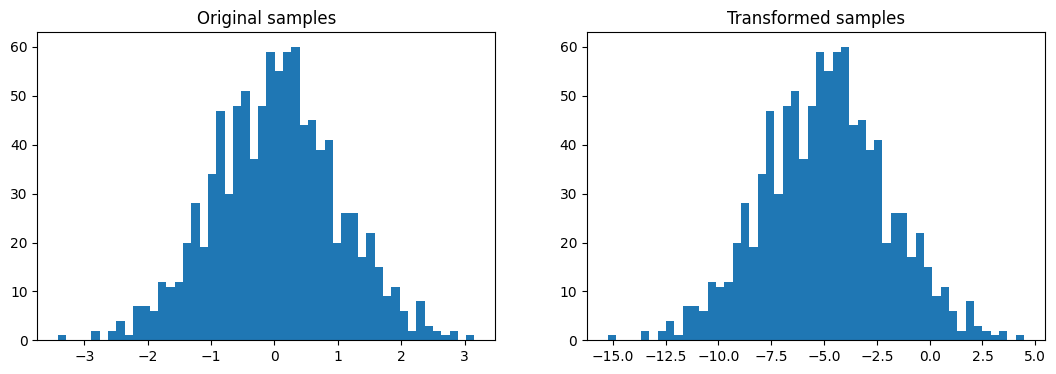

In [35]:
# Plot the original and transformed samples

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13, 4))

plt.subplot(1, 2, 1)
plt.hist(z.numpy(), bins=50)
plt.title("Original samples")

plt.subplot(1, 2, 2)
plt.hist(x.numpy(), bins=50)
plt.title("Transformed samples")
plt.show()

#shifted and wider spread

In [36]:
# Chain the bijectors together

scale_and_shift = tfb.Chain([shift,scale])
#they are applied in reverse order, like matrices
scale_and_shift = shift(scale)
#make sure we know the difference between calling on a tensor and another bijector

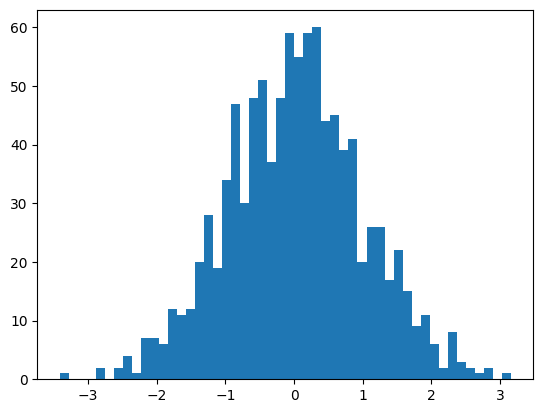

In [37]:
# Pass the transformed samples through the inverse method of each bijector

x_inv = scale_and_shift.inverse(x)
plt.hist(x_inv, bins = 50)
plt.show()
#back to start

#### Batched bijectors

In [38]:
# Create a batched Softfloor bijector

softfloor = tfb.Softfloor(temperature=[0.01,0.1,1.])

In [39]:
# Pass some test points through the bijector
import numpy as np

test_pts = np.linspace(-2,2,1000)
transformed_pts = softfloor(test_pts[:,None])

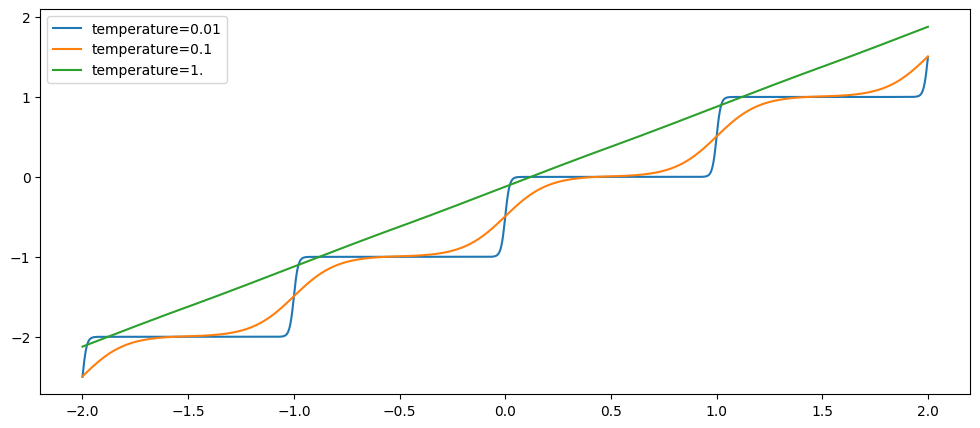

In [40]:
# Plot the transformed samples

plt.figure(figsize=(12, 5))
plt.plot(test_pts, transformed_pts[:, 0], label='temperature=0.01')
plt.plot(test_pts, transformed_pts[:, 1], label='temperature=0.1')
plt.plot(test_pts, transformed_pts[:, 2], label='temperature=1.')
plt.legend()
plt.show()

#### Computing log-probs of transformed samples

In [41]:
# Create an Exp bijector

exp = tfb.Exp()


In [42]:
# Compute the exp of the standard Normal samples

x = exp.forward(z)

Recall the change of variables formula:

$$
\log p_X(\mathbf{x}) = \log p_Z(\mathbf{z}) - \log \hspace{0.1ex}\left|\det J_f(\mathbf{z}) \right|
$$

In [43]:
# Use log_det_jacobian to compute log_probs of transformed samples

logprob_x = normal.log_prob(z) - exp.forward_log_det_jacobian(z,event_ndims=0)
logprob_x

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([-2.8749738 , -2.232244  , -0.8444885 , -1.1358048 , -6.9220724 ,
       -0.72511566, -0.78634745, -1.2782917 , -0.55238926, -1.6525192 ,
       -1.4907941 , -2.3731327 , -0.71622634, -0.4209451 , -0.80057377,
       -1.7774862 , -0.9599469 , -0.51535904, -0.5116481 , -0.50934136,
       -1.6860478 , -0.7974928 , -0.81922567, -2.051467  , -0.58524835,
       -0.72287655, -1.4416559 , -1.6076007 , -1.4739747 , -0.42612797,
       -0.4361307 , -1.078715  , -3.021655  , -0.41937053, -3.8723109 ,
       -1.3558943 , -0.9608424 , -0.42661446, -1.9100846 , -3.0676937 ,
       -0.99073094, -1.6405346 , -0.764959  , -0.4196552 , -1.3341458 ,
       -1.2696893 , -2.4998724 , -2.5880804 , -0.43821222, -0.6999829 ,
       -0.9323619 , -0.4348014 , -0.42164832, -1.1498498 , -1.0317628 ,
       -3.5398426 , -3.4730802 , -0.9417878 , -2.0743775 , -1.9560521 ,
       -3.1567707 , -1.305935  , -2.0141509 , -0.72734207, -1.4380419 ,
       -3.59399

And using the inverse transformation:

$$
\log p_X(\mathbf{x}) = \log p_Z(\mathbf{z}) + \log \hspace{0.1ex}\left|\det J_{f^{-1}}(\mathbf{x}) \right|
$$

In [44]:
# Repeat the calculation with the inverse_log_det_jacobian

logprob_x2 = normal.log_prob(z) + exp.inverse_log_det_jacobian(x,event_ndims=0)
logprob_x2

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([-2.8749738 , -2.232244  , -0.8444885 , -1.1358048 , -6.9220724 ,
       -0.72511566, -0.78634745, -1.2782917 , -0.55238926, -1.6525192 ,
       -1.4907941 , -2.3731327 , -0.71622634, -0.4209451 , -0.80057377,
       -1.7774862 , -0.9599469 , -0.51535904, -0.5116481 , -0.50934136,
       -1.6860478 , -0.7974928 , -0.81922567, -2.051467  , -0.58524835,
       -0.72287655, -1.4416559 , -1.6076007 , -1.4739747 , -0.42612797,
       -0.4361307 , -1.078715  , -3.021655  , -0.41937053, -3.8723109 ,
       -1.3558943 , -0.9608424 , -0.42661446, -1.9100846 , -3.0676937 ,
       -0.99073094, -1.6405346 , -0.764959  , -0.4196552 , -1.3341458 ,
       -1.2696893 , -2.4998724 , -2.5880804 , -0.43821222, -0.6999829 ,
       -0.9323619 , -0.4348014 , -0.42164832, -1.1498498 , -1.0317628 ,
       -3.5398426 , -3.4730802 , -0.9417878 , -2.0743775 , -1.9560521 ,
       -3.1567707 , -1.305935  , -2.0141509 , -0.72734207, -1.4380419 ,
       -3.59399

In [45]:
#These are the same
np.allclose(logprob_x, logprob_x2)

True

#### The TransformedDistribution
The `TransformedDistribution` class provides a consistent API for distributions defined by bijectors and base distributions.

In [46]:
# Define the log-normal distribution with TransformedDistribution

transformed_normal = tfd.TransformedDistribution(normal,exp)


In [47]:
# Confirm the log-probs of the transformed samples are the same as under a log-normal distribution
#x is a sample from the transformed normal technically
transformed_normal.log_prob(x)
#same as
np.allclose(transformed_normal.log_prob(x), tfd.LogNormal(loc=0, scale=1).log_prob(x))

True

`TransformedDistribution` objects can also be defined by calling the bijector on the base distribution.

In [48]:
# Recreate the log-normal TransformedDistribution

#this a gain different to calling exponential on individual components, we are calling it on a distribution, it does the same as 2 cells above
lognormal = exp(normal)
lognormal

<tfp.distributions.TransformedDistribution 'expNormal' batch_shape=[] event_shape=[] dtype=float32>

The `TransformedDistribution` infers the batch shape by broadcasting the batch shapes of the base distribution and the bijector.

In [49]:
# Create a TransformedDistribution from a batched bijector

softfloor = tfb.Softfloor(temperature=[0.01,0.1,1.])
normal = tfd.Normal(loc = 0,scale = 1)
trans_dist = tfd.TransformedDistribution(normal, softfloor)
trans_dist
#now has batch shape of 3 thanks to the bijector

<tfp.distributions.TransformedDistribution 'softfloorNormal' batch_shape=[3] event_shape=[] dtype=float32>

In [50]:
# Test the new TransformedDistribution

print(trans_dist.sample())

trans_dist.log_prob(tf.random.normal((3,)))

tf.Tensor([-1.        -0.8634043 -0.9750562], shape=(3,), dtype=float32)


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.247376 , -1.2236986, -1.9750581], dtype=float32)>

In [51]:
# Set a scaling lower triangular matrix

fill_tril = tfb.FillScaleTriL()
#the vector you pass in has to be able to be split into a lower triangular
#can pass it the sample batch number first ()
scale_trill = fill_tril(tf.random.normal((2,6)))
scale_trill

#this is guaranteed to be invertible

<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[ 0.7068614 ,  0.        ,  0.        ],
        [ 0.71306586,  1.5623676 ,  0.        ],
        [ 0.60104465, -0.15869442,  1.5904243 ]],

       [[ 0.715091  ,  0.        ,  0.        ],
        [-0.08651862,  1.7292261 ,  0.        ],
        [ 0.53476363, -0.22284868,  1.3160642 ]]], dtype=float32)>

In [52]:
# Define a bijector that operates on a rank >= 1 event space

scale_matvec_tril = tfb.ScaleMatvecTriL(scale_trill)

In [53]:
# Define TransformedDistribution with a batch and event shape

#note that the above has an event space of 3, so this needs to as well
mv_normal = tfd.MultivariateNormalDiag(loc = [0,0,0], scale_diag = [1,1,1])
mvn_tril = tfd.TransformedDistribution(mv_normal, scale_matvec_tril)
mvn_tril

<tfp.distributions.TransformedDistribution 'scale_matvec_trilMultivariateNormalDiag' batch_shape=[2] event_shape=[3] dtype=float32>

In [54]:
# Sample from the transformed distribution

mvn_tril.sample()
#gives us 2 batches of 3d samples

mvn_tril.log_prob(tf.random.normal((2,3)))
#this will broadcast
mvn_tril.log_prob(tf.random.normal((3,)))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-4.366444, -4.42789 ], dtype=float32)>

_Exercise._ Construct the distribution $\mathcal{N}(\mu, \Sigma)$, where $\mu = [0.5, -0.5]^T$ and $\Sigma = \left[\begin{array}{cc} 2 & 1\\ 1 & 2\end{array}\right]$, first using a `tfd.MultivariateNormalTriL` object, and then using a `tfd.TransformedDistribution` object with a zero-mean Gaussian with identity covariance matrix as a base distribution. Verify that the two representations are mathematically equivalent by computing log probs on a given sample.

<a class="anchor" id="arflows"></a>
## Autoregressive flows

Autoregressive networks are a class of density estimators that explicitly model the data distribution as the product of conditional distributions

$$
p(\mathbf{x}) = \prod_{i=1}^D p(x_i\mid x_{1:i-1})
$$

where $\mathbf{x}\in\mathbb{R}^D$ is a data example, and $x_{1:i-1}$ is the subvector of $\mathbf{x}$ consisting of all elements up to the $(i-1)$-th entry. Autoregressive models are a powerful class of generative model and several architectures have been developed, including the MADE ([Germain et al 2015](#Germain15)), PixelRNN ([van den Oord et al 2016a](#vandenOord16a)), PixelCNN ([van den Oord et al 2016b](#vandenOord16b)), NADE ([Larochelle & Murray 2011](#Larochelle11)), and WaveNet ([van den Oord et al 2016c](#vandenOord16c)).

An example is a model whose conditional density is a Gaussian:

$$
p(x_i \mid x_{1:i-1}) = \mathcal{N}(x_i \mid \mu_i, \sigma_i^2),\quad i=1,\ldots, D\tag{8}
$$

where the mean and standard deviations are provided by a neural network

$$
\left.
\begin{array}{rcl}
\mu_i \hspace{-1ex}&=& \hspace{-1ex}f_{\mu_i}(x_{1:i-1})\\
\sigma_i \hspace{-1ex}&=& \hspace{-1ex}f_{\sigma_i}(x_{1:i-1})
\end{array}
\quad
\right\}
\quad
i=1,\ldots D.
$$

To sample from such a model, we sample from a noise vector

$$
\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}),\qquad \mathbf{z}\in\mathbb{R}^D
$$

and recursively compute

$$
x_i = f_{\sigma_i}(x_{1:i-1})z_i + f_{\mu_i}(x_{1:i-1}),\qquad i=1,\ldots, D.\tag{9}
$$

This procedure can be visualised in the following diagram.

<img src="figures/ar_flow_sampling.png" alt="Sampling in the autoregressive model" style="width: 500px;"/>
<center>Sampling $x_i$ sequentially with \eqref{ar_forward} in the autoregressive model \eqref{gaussian_ar}</center>

This recursive computation is a deterministic transformation of the underlying noise variable $\mathbf{z}$ and can be interpreted as a normalising flow:

$$
p(\mathbf{z}) \overset{f}{\Rightarrow} p(\mathbf{x})
$$

The forward transformation is given by \eqref{ar_forward}, where the $x_i$ are computed sequentially. Note that we need to enforce $f_{\sigma_i} > 0$ to ensure invertibility. In this case, the transformation can be inverted, and the inverse transformation is given by

$$
z_i = \frac{x_i - f_{\mu_i}(x_{1:i-1})}{f_{\sigma_i}(x_{1:i-1})},\qquad i=1,\ldots, D.\tag{10}
$$

There is an important practical difference between \eqref{ar_forward} and \eqref{ar_inverse}. In the forward pass \eqref{ar_forward}, each $x_i$ depends on all the elements $x_{1:i-1}$ and so we need to make $D$ passes through the network to sample a data point $\mathbf{x}\in\mathbb{R}^D$.

However, in the inverse pass \eqref{ar_inverse}, the calculation of each $z_i$ is independent from each other, and we already have all of the xs and so the inverse transformation can be parallelised:

$$
\mathbf{z} = \frac{\mathbf{x} - f_{\mathbf{\mu}}(\mathbf{x})}{f_{\mathbf{\sigma}}(\mathbf{x})},\tag{11}
$$

where we denote $f_{\mathbf{\mu}}(\mathbf{x}):=\left(f_{\mu_i}(x_{1:i-1})\right)_{i\in\{1,\ldots,D\}}$ and $f_{\mathbf{\sigma}}(\mathbf{x}):=\left(f_{\sigma_i}(x_{1:i-1})\right)_{i\in\{1,\ldots,D\}}$.

This calculation can be visualised in the following diagram.

<img src="figures/ar_flow_inference.png" alt="Sampling in the autoregressive model" style="width: 500px;"/>
<center>In the inverse transformation \eqref{ar_inverse} all $x_i$ are known and so each $z_i$ can be computed independently, enabling the parallelised computation \eqref{ar_inverse_parallel}</center>

#### The Jacobian determinant
Note that due to the autoregressive property, we have

$$
\frac{\partial f_{\mu_i}}{\partial x_j} = \frac{\partial f_{\sigma_i}}{\partial x_j} = 0,\qquad \text{for }j\ge i.
$$

This gives us

$$
\frac{\partial z_i}{\partial x_j} = 
\left\{
\begin{array}{ll}
\frac{1}{f_{\sigma_i}(x_{1:i-1})},&j=i\\
0,&j>i
\end{array}
\right.
$$

so the Jacobian matrix $\partial \mathbf{z} / \partial\mathbf{x} \in\mathbb{R}^{D\times D}$ is lower triangular, and the determinant can easily be calculated as the product of entries on the diagonal.

We can then apply the change of variables formula to derive the expression for the transformed log-density:

$$
\begin{align}
\log p(\mathbf{x}) &= \log p(\mathbf{z}) + \log\,\left|\,\det\frac{\partial\mathbf{z}}{\partial\mathbf{x}}\,\right|\\
&= \log p(\mathbf{z}) - \sum_{i=1}^D \log f_{\sigma_i}(x_{1:i-1})
\end{align}
$$

#### Masked autoregressive flow (MAF)
An implementation of the conditional-Gaussian autoregressive model described above is the masked autoregressive flow (MAF) ([Papamakarios et al 2017](#Papamakarios17)), where the autoregressive functions $f_{\mu_i}(x_{1:i-1})$ and $f_{\sigma_i}(x_{1:i-1})$ are implemented using the masked autoencoder (MADE) architecture ([Germain et al 2015](#Germain15)).

The MADE is based on an autoencoder network, where the inputs and outputs are the same, and the network is trained to reconstruct the inputs. An example is the MLP depicted in the following diagram.

<img src="figures/unmasked_autoencoder.png" alt="Autoencoder model" style="width: 650px;"/>
<center>An autoencoder model, where the outputs are a reconstruction of the inputs</center>

The MADE turns the autoencoder into an autoregressive network by applying a masking pattern to the weights of the network. For example, in the autoencoder network shown above, the weight matrices $\mathbf{W}^{(0)}\in\mathbb{R}^{4\times3}$, $\mathbf{W}^{(1)}\in\mathbb{R}^{4\times4}$ and $\mathbf{W}^{(2)}\in\mathbb{R}^{3\times4}$ could be multiplied elementwise by the following binary masks respectively:

$$
\mathbf{M}^{(0)}=
\left(
\begin{array}{ccc}
0 & 1 & 1\\
0 & 1 & 0\\
0 & 1 & 1\\
0 & 1 & 1
\end{array}
\right\},\quad
\mathbf{M}^{(1)}=
\left(
\begin{array}{cccc}
0 & 1 & 0 & 0\\
1 & 1 & 1 & 1\\
1 & 1 & 1 & 1\\
0 & 1 & 0 & 0
\end{array}
\right)\quad
\mathbf{M}^{(2)}=
\left(
\begin{array}{cccc}
1 & 1 & 1 & 1\\
0 & 0 & 0 & 0\\
1 & 0 & 0 & 1
\end{array}
\right)
$$

which would produce the following connectivity pattern:

<img src="figures/masked_autoencoder.png" alt="Masked autoencoder (MADE)" style="width: 650px;"/>
<center>A masked autoencoder (MADE) model, where selected weight connections are set to zero in order to produce the autoregressive property</center>

In the above figure, the red connections carry information that only depends on the input $x_2$, whereas the green connections carry information that depends on the inputs $x_2$ and $x_3$. Therefore the output $\hat{x}^{(3)}_2$ is independent of all the inputs (it only depends on the bias $b^{(3)}_2$), the output $\hat{x}^{(3)}_3$ depends only on the input $x_2$ (which will be known after a first pass through the network), and the output $\hat{x}^{(3)}_1$ depends on $x_2$ and $x_3$ (which will both be known after the second pass through the network).

In fact, the MADE outputs mean and standard deviation parameters for each output (when the data is assumed normal), and so the architecture is more precisely depicted in the following figure. Typically use no activation for means, and either an exponential activation for sd to ensure positivity, or take it as the log of the sd.

<img src="figures/made.png" alt="Masked autoencoder (MADE)" style="width: 750px;"/>
<center>The MADE network produces mean and standard deviation parameters for each output</center>

The forward pass of the masked autoregressive flow (MAF) is summarised in the following pseudocode. The forward input `z` is a length-$D$ vector that is sampled from a diagonal Gaussian $\mathcal{N}(\mathbf{0}, \mathbf{I})$, and a trained `made` network that outputs two length-$D$ arrays `mu` and `sigma`.

-------
>```
> def forward(z):
> 	x = tf.zeros_like(z)
> 	for _ in range(D):
>     	mu, sigma = made(x)
>     	x = z * sigma + mu
> 	return x
>```
-------

Notice how $D$ passes are required through the loop. At each pass, one element of the array `x` is updated correctly. Correctly updated elements of `x` are unaffected by subsequent passes.

Pseudocode for the inverse pass is given below. Here, the input `x` is a length-$D$ data example, and again the `made` network outputs two length-$D$ arrays `mu` and `sigma`.

-------
> ```
> def inverse(x):
> 	mu, sigma = made(x)
>  	return (x - mu) / sigma
> ```
-------

The inverse pass does not require any loops, and can be quickly computed in parallel.

#### Inverse autoregressive flow (IAF)
The autoregressive flow presented above can trivially be inverted, so that the forward pass becomes

$$
\mathbf{x} = \frac{\mathbf{z} - f_{\mathbf{\mu}}(\mathbf{z})}{f_{\mathbf{\sigma}}(\mathbf{z})},
$$

and the inverse pass is given by the recursive relation

$$
z_i = f_{\sigma_i}(z_{1:i-1})x_i + f_{\mu_i}(z_{1:i-1}),\qquad i=1,\ldots, D.
$$

This inverse autoregressive flow (IAF) was proposed in [Kingma et al 2016](#Kingma16) to improve the posterior approximation in variational autoencoders. It was also used in [van den Oord et al 2018](#vandenOord18) as a proposed solution to the slow sequential sampling of audio in the [WaveNet](#vandenOord2016c) architecture.

MAKES FORWARD FLOW FAST.

<a class="anchor" id="maf"></a>
## Masked autoregressive flow (MAF)

The masked autoregressive flow is implemented in TensorFlow Probability with the `AutoregressiveNetwork` and `MaskedAutoregressiveFlow` bijectors.

In [55]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

The `AutoregressiveNetwork` implements the MADE network architecture. Despite being found in the `bijectors` module, this object does not represent a bijective transformation, or have the same methods as other bijectors.

In [56]:
# Create a MADE network with the AutoregressiveNetwork bijector

#2 parameters predicted for each input feature
made = tfb.AutoregressiveNetwork(2, event_shape = [3], hidden_units=[16,16], activation = "sigmoid")

In [57]:
#These two cells illustrate process
Z = tf.random.normal((3,))

In [58]:
# Pass some dummy inputs through the MADE

inputs = tf.random.normal((1,3))
print(inputs)
mu, sigma = made(inputs)[:,:,0],made(inputs)[:,:,1]
#mean and sd for each input

it1 = sigma*Z + mu
print(it1)

mu, sigma = made(it1)[:,:,0],made(it1)[:,:,1]
it2= sigma*Z + mu
print(it2)

mu, sigma = made(it2)[:,:,0],made(it2)[:,:,1]
it3= sigma*Z + mu
print(it3)

print("---"*50)


tf.Tensor([[ 0.8171241  -0.74435914 -0.24295475]], shape=(1, 3), dtype=float32)
tf.Tensor([[0.         0.33096153 0.8463551 ]], shape=(1, 3), dtype=float32)
tf.Tensor([[0.         0.306693   0.83745015]], shape=(1, 3), dtype=float32)
tf.Tensor([[0.         0.306693   0.83786535]], shape=(1, 3), dtype=float32)
------------------------------------------------------------------------------------------------------------------------------------------------------


In [59]:
#bigger example
made2 = tfb.AutoregressiveNetwork(2, event_shape = [10], hidden_units=[16,16], activation = "sigmoid")
Z = tf.random.normal((10,))

In [60]:
#batch of 1
inputs = tf.random.normal((1,10))
print(inputs)
for i in range(10):
    mu, sigma = made2(inputs)[:,:,0],made2(inputs)[:,:,1]
    inputs = sigma*Z + mu
    print(inputs)
#see how they get updated sequentially and then dont change

tf.Tensor(
[[-1.3129655   0.6195824  -0.54344255 -0.9455532  -0.4999775  -0.5442793
   0.79605764 -0.8266971  -0.5742205   0.8895859 ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[ 0.          0.02773036 -0.0282424   0.39940503  0.0056645   0.1496449
   0.10574604  0.08889548  1.5266794   0.47911447]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[ 0.          0.02786988 -0.02393045  0.40248775  0.00486494  0.13211803
   0.11801797  0.09668759  1.5201344   0.5027938 ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[ 0.          0.02786988 -0.02393011  0.40248978  0.00488402  0.13207981
   0.11801203  0.09670518  1.5202925   0.5028359 ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[ 0.          0.02786988 -0.02393011  0.40248978  0.00488402  0.1320799
   0.11801184  0.09670551  1.5202935   0.5028363 ]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[ 0.          0.02786988 -0.02393011  0.40248978  0.00488402  0.1320799
   0.11801184  0.09670551  1.5202935   0.5028363 ]], shape=(1, 10), dtype=float

In [61]:
# Inspect the network variables

made.variables

[<tf.Variable 'dense/kernel:0' shape=(3, 16) dtype=float32, numpy=
 array([[ 0.48702997, -0.01471728, -0.51440567, -0.30391935, -0.02553761,
         -0.48743638, -0.26622444,  0.01709872,  0.08520448, -0.15986896,
         -0.24539703, -0.11557436,  0.32639778,  0.2937113 ,  0.5579453 ,
         -0.26646748],
        [ 0.        ,  0.        , -0.        ,  0.        , -0.        ,
          0.        ,  0.        , -0.        ,  0.24381942,  0.20818943,
          0.338884  ,  0.16408837,  0.15339172, -0.26459256, -0.4739142 ,
         -0.22468162],
        [ 0.        ,  0.        ,  0.        , -0.        ,  0.        ,
         -0.        , -0.        , -0.        , -0.        , -0.        ,
         -0.        , -0.        , -0.        , -0.        ,  0.        ,
         -0.        ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(16,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>,
 <tf.Variable 'dense

The `AutoregressiveNetwork` instance can be used in the `MaskedAutoregressiveFlow` bijector.

In [62]:
# Create a MAF bijector

#could pass keras model in but then we would have to make sure it was autoregressive
maf_bijector = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)


In [63]:
# The variables are automatically tracked by the MAF bijector

maf_bijector.variables

(<tf.Variable 'dense_2/kernel:0' shape=(16, 6) dtype=float32, numpy=
 array([[ 0.        ,  0.        ,  0.40514982, -0.31842932,  0.25093246,
         -0.4374588 ],
        [ 0.        ,  0.        ,  0.02474016, -0.13905668,  0.21348453,
         -0.44127887],
        [-0.        ,  0.        , -0.23924005, -0.12464514,  0.36413234,
         -0.02266693],
        [ 0.        ,  0.        , -0.08856699,  0.13617313,  0.32016623,
         -0.2463659 ],
        [ 0.        , -0.        , -0.37866852, -0.17224658, -0.5176044 ,
         -0.1356177 ],
        [ 0.        , -0.        , -0.15685812, -0.01729035, -0.12699923,
         -0.13425556],
        [-0.        , -0.        ,  0.06761557, -0.3092593 , -0.4175712 ,
         -0.12204474],
        [-0.        ,  0.        , -0.2749052 , -0.08281374,  0.3705151 ,
         -0.2442278 ],
        [ 0.        , -0.        , -0.        , -0.        , -0.49361956,
         -0.23722276],
        [-0.        , -0.        ,  0.        ,  0.       

Note that the outputs of the MADE are used as shift and log-scale predictions in the MAF for improved numerical stability.

In [64]:
# Test the bijector on a dummy input
maf_bijector.forward(tf.random.normal((1,3)))


<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.21704122, -1.2601216 , -0.05252799]], dtype=float32)>

In [65]:
# An inverse autoregressive flow (IAF) can be created using the Invert bijector

iaf_bijector = tfb.Invert(maf_bijector)

In [66]:
# Define the transformed distribution

normal = tfd.Normal(loc = 0, scale = 1)
maf = tfd.TransformedDistribution(normal, maf_bijector)
maf

<tfp.distributions._TransformedDistribution 'masked_autoregressive_flowNormal' batch_shape=[] event_shape=[] dtype=float32>

#### Toy dataset example
We will demonstrate the MAF by reproducing the first example from the paper ([Papamakarios et al 2017](#Papamakarios17)), where the target density is defined by

$$
p(x_1,x_2) = \mathcal{N}(x_2 |0, 4)\mathcal{N}(x_1 \mid \frac{1}{4}x_2^2, 1).
$$

We will implement this target distribution using the `JointDistributionSequential` class.

In [77]:
# Define the target distribution

#we pretend we dont know the target

#distributions can depend on previous ones in the list
target = tfd.JointDistributionSequential([
    tfd.Normal(loc = 0, scale = 4),
    lambda x2: tfd.Normal(loc = 0.25 * (x2**2), scale  = 1)
])
a = target.sample(3) # sample 3
print(a)
#gives each variable in a separate list
#the first corresponds to x2, the second to x1 (in opposite order)

tf.stack([a[1], a[0]],axis = 1) #now 3 samples of 2

[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.8443146,  4.468502 , -1.8872465], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.70258605, 4.0594196 , 0.88310087], dtype=float32)>]


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.70258605, -2.8443146 ],
       [ 4.0594196 ,  4.468502  ],
       [ 0.88310087, -1.8872465 ]], dtype=float32)>

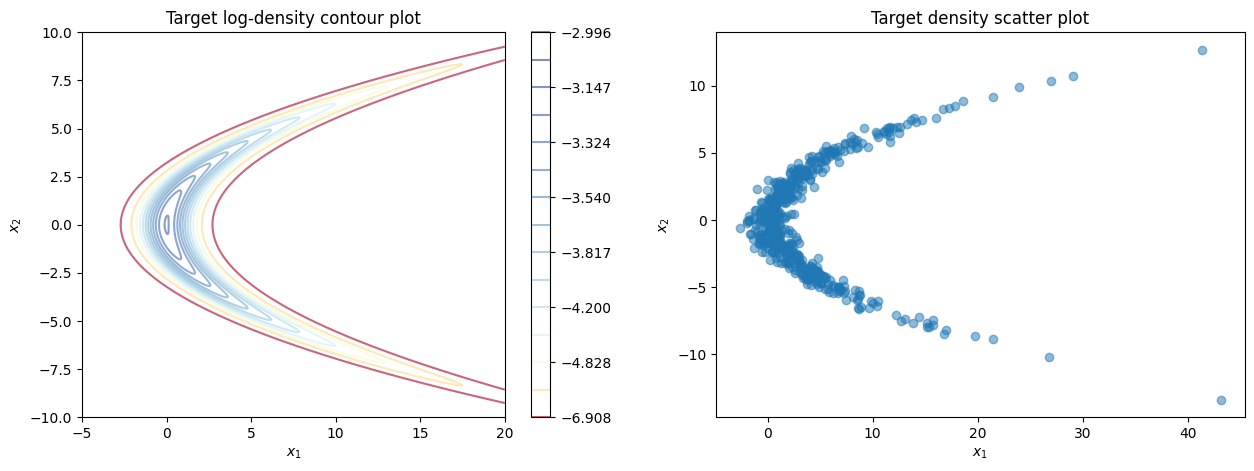

In [68]:
# Make a contour and scatter plot from the target density

import numpy as np
import matplotlib.pyplot as plt

X, Y = np.meshgrid(np.linspace(-5, 20, 1000), np.linspace(-10, 10, 500))
Z = target.log_prob(Y, X)

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
levels = np.log(np.linspace(0.001, 0.05, 15))
plt.contour(X, Y, Z, levels, alpha=0.6, cmap='RdYlBu')
plt.title("Target log-density contour plot")
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plt.title("Target density scatter plot")
samples = target.sample(500)
plt.scatter(samples[1], samples[0], alpha=0.5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

#### Create a training Dataset

In [86]:
# Define a generator for the dataset

batch_size = 128
def datagen():
    while True:
        batch = target.sample(batch_size)
        #this returns two tensors, so stack them
        batch = tf.stack([batch[1], batch[0]],axis = -1)
        yield batch

print(datagen())
#if we do the following, then every time we call it we get another batch:
next(datagen())

<generator object datagen at 0x000001D411321380>


<tf.Tensor: shape=(128, 2), dtype=float32, numpy=
array([[ 5.54594636e-01,  2.16457820e+00],
       [-1.14954233e-01, -9.42954302e-01],
       [-9.15472269e-01, -2.93723196e-01],
       [ 2.43377638e+00,  1.67036724e+00],
       [ 2.88608646e+00, -3.76774073e+00],
       [ 6.32501984e+00,  4.38522291e+00],
       [ 2.38680363e+00,  2.98477697e+00],
       [-2.79434413e-01,  7.60812163e-01],
       [ 9.83890343e+00,  6.03667879e+00],
       [ 1.38744392e+01,  7.41141033e+00],
       [ 7.23282993e-02,  1.06681788e+00],
       [ 1.04848361e+00,  2.78948307e+00],
       [ 9.69855404e+00,  5.79777145e+00],
       [ 6.37188911e-01, -2.24648023e+00],
       [ 5.08912039e+00,  4.98949814e+00],
       [-4.79527116e-02,  5.95596671e-01],
       [ 1.16796327e+00, -1.87132311e+00],
       [ 2.16752005e+00,  1.07939637e+00],
       [-6.07957125e-01, -5.80186307e-01],
       [ 2.92832775e+01, -1.08724060e+01],
       [ 1.43774164e+00, -1.13693334e-01],
       [ 5.00059319e+00,  4.80507755e+00],
    

In [110]:
# Use the generator to make a Dataset

dataset = tf.data.Dataset.from_generator(datagen,output_types = tf.float32)

In [104]:
# Inspect a dataset element

for ele in dataset.take(1):
    print(ele)
#correct shape

tf.Tensor(
[[ 4.2577062e+00  3.6587279e+00]
 [ 2.4181299e+00  7.7579850e-01]
 [ 3.9942515e+00  3.9944599e+00]
 [ 1.9725726e+00  5.9358025e-01]
 [ 1.3958436e+00  2.2391801e+00]
 [ 2.0625408e+00 -3.2041898e+00]
 [ 1.6649559e+00 -1.9887104e+00]
 [ 1.0458415e+01  6.7818918e+00]
 [ 8.2093544e+00 -5.7232628e+00]
 [ 8.5310116e+00 -6.1604228e+00]
 [ 2.8557410e+00 -3.9632072e+00]
 [ 1.9169830e+00  2.5197361e+00]
 [-1.1647556e+00 -1.9353475e-01]
 [ 5.2935165e-01 -5.9533332e-02]
 [ 1.1881783e+00 -8.7432587e-01]
 [ 1.5646323e+00 -1.7678518e+00]
 [-1.0441941e-01  1.7467766e+00]
 [ 5.9036231e+00  4.4557076e+00]
 [ 8.4397042e-01  8.6501718e-01]
 [ 2.1858501e+00 -2.6457891e+00]
 [ 1.6043422e+00  5.3124338e-01]
 [ 4.0137205e+00 -3.0275450e+00]
 [ 1.7407722e+01 -8.6245642e+00]
 [ 1.2368296e+00  1.4790224e+00]
 [ 5.9343266e+00  4.7956071e+00]
 [ 2.9637434e+00  3.5395391e+00]
 [ 1.7277105e+00  4.2637450e-01]
 [ 2.5028906e+00 -3.6819601e+00]
 [-9.1504765e-01 -1.0870602e+00]
 [ 4.7389209e-01 -9.1899908e-01]

#### Define and train the MAF

In [114]:
# Define the MAF

#need multivariate base
base = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
made = tfb.AutoregressiveNetwork(params = 2, hidden_units=[10,10], activation = "relu")
maf_bijector = tfb.MaskedAutoregressiveFlow(made)
maf = tfd.TransformedDistribution(base, maf_bijector)
#now we have to train it

In [115]:
# Use a custom training loop to train the flow

epochs = 15
steps_per_epoch = 100
rmsprop = tf.keras.optimizers.RMSprop()

#tf function for training - gets converted to graph
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        #negative log likelihood loss of transformed distribution
        nll = -tf.reduce_mean(maf.log_prob(inputs))
    grads = tape.gradient(nll,maf.trainable_variables)
    #seen before
    rmsprop.apply_gradients(zip(grads, maf.trainable_variables))
    return nll

for epoch in range(epochs):
    epoch_loss = tf.keras.metrics.Mean()
    # dont need this as initialising the metric each time, only need if passing the metric in as an argument that is already initialised: epoch_loss.reset_state()
    #toy dataset so dataset is infinite, just take this per epoch
    for inputs in dataset.take(steps_per_epoch):
        batch_loss = train_step(inputs)
        epoch_loss.update_state(batch_loss)
    print("End of epoch {}, loss: {}".format(epoch + 1, epoch_loss.result()))

End of epoch 1, loss: 24.322410583496094
End of epoch 2, loss: 22.132396697998047
End of epoch 3, loss: 18.648334503173828
End of epoch 4, loss: 15.298890113830566
End of epoch 5, loss: 13.683030128479004
End of epoch 6, loss: 11.744453430175781
End of epoch 7, loss: 10.608772277832031
End of epoch 8, loss: 9.49655532836914
End of epoch 9, loss: 8.408474922180176
End of epoch 10, loss: 7.840859889984131
End of epoch 11, loss: 7.259369373321533
End of epoch 12, loss: 6.813386917114258
End of epoch 13, loss: 6.539639949798584
End of epoch 14, loss: 6.135678291320801
End of epoch 15, loss: 5.983501434326172


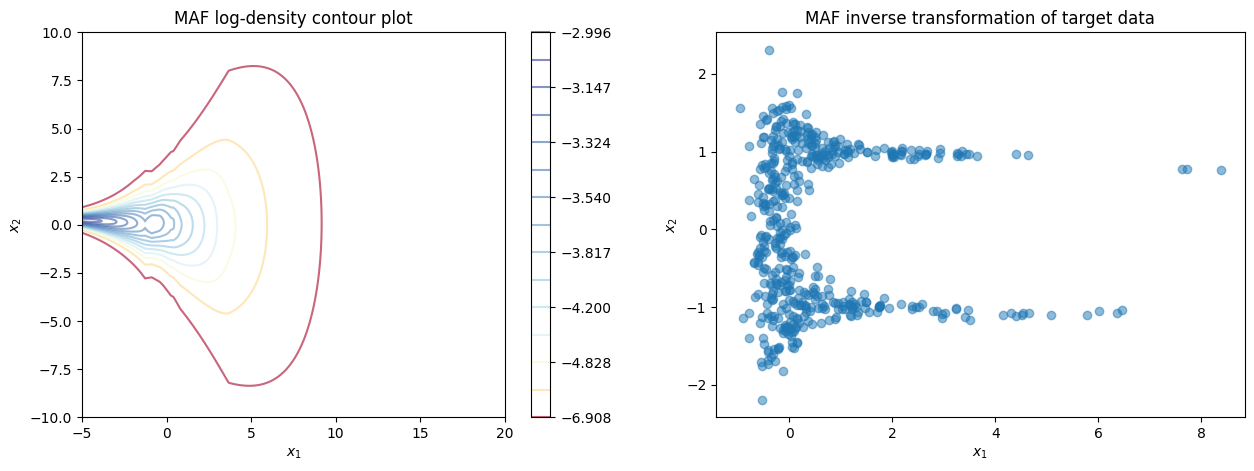

In [116]:
# Make a contour and scatter plot from the target density

X, Y = np.meshgrid(np.linspace(-5, 20, 1000), np.linspace(-10, 10, 500))
X, Y = X.astype(np.float32), Y.astype(np.float32)
Z = maf.log_prob(tf.stack([X, Y], axis=-1))

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
levels = np.log(np.linspace(0.001, 0.05, 15))
plt.contour(X, Y, Z, levels, alpha=0.6, cmap='RdYlBu')
plt.title("MAF log-density contour plot")
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plt.title("MAF inverse transformation of target data")
target_samples = target.sample(500)
samples = maf_bijector.inverse(tf.stack([target_samples[1], target_samples[0]], axis=-1))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

#after applying the inverse, should end up with the plot we showed earlier, and we arent, so model is not powerful enough

#### Multilayer MAF
The above normalising flow is not yet powerful enough to fit the data, note that the conditionals are unimodal by construction. However, we can make more flexible normalising flows by stacking multiple layers of MAF together.

In [117]:
# Define the stack of bijectors

    
def get_maf_bijector():
    made = tfb.AutoregressiveNetwork(params=2, hidden_units=[10, 10], activation='relu')
    return tfb.MaskedAutoregressiveFlow(made)

num_layers = 3
maf_bijs = []
for _ in range(num_layers):
    maf_bijs.append(get_maf_bijector())
    #swap order of variables each iteration
    #this permutes the indices of the incoming tensor, since the bijector returns in reverse order
    maf_bijs.append(tfb.Permute([1, 0]))
    
maf_bijector = tfb.Chain(list(reversed(maf_bijs)))
maf = tfd.TransformedDistribution(base, maf_bijector)


In [118]:


# Use a custom training loop to train the flow

epochs = 15
steps_per_epoch = 100
rmsprop = tf.keras.optimizers.RMSprop()

#tf function for training - gets converted to graph
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        #negative log likelihood loss of transformed distribution
        nll = -tf.reduce_mean(maf.log_prob(inputs))
    grads = tape.gradient(nll,maf.trainable_variables)
    #seen before
    rmsprop.apply_gradients(zip(grads, maf.trainable_variables))
    return nll

for epoch in range(epochs):
    epoch_loss = tf.keras.metrics.Mean()
    # dont need this as initialising the metric each time, only need if passing the metric in as an argument that is already initialised: epoch_loss.reset_state()
    #toy dataset so dataset is infinite, just take this per epoch
    for inputs in dataset.take(steps_per_epoch):
        batch_loss = train_step(inputs)
        epoch_loss.update_state(batch_loss)
    print("End of epoch {}, loss: {}".format(epoch + 1, epoch_loss.result()))

End of epoch 1, loss: 7.7702860832214355
End of epoch 2, loss: 4.571493625640869
End of epoch 3, loss: 4.4672017097473145
End of epoch 4, loss: 4.373654842376709
End of epoch 5, loss: 4.3534255027771
End of epoch 6, loss: 4.3846659660339355
End of epoch 7, loss: 4.346767902374268
End of epoch 8, loss: 4.336465835571289
End of epoch 9, loss: 4.337509632110596
End of epoch 10, loss: 4.304687023162842
End of epoch 11, loss: 4.295334339141846
End of epoch 12, loss: 4.286968231201172
End of epoch 13, loss: 4.293999195098877
End of epoch 14, loss: 4.271691799163818
End of epoch 15, loss: 4.267129898071289


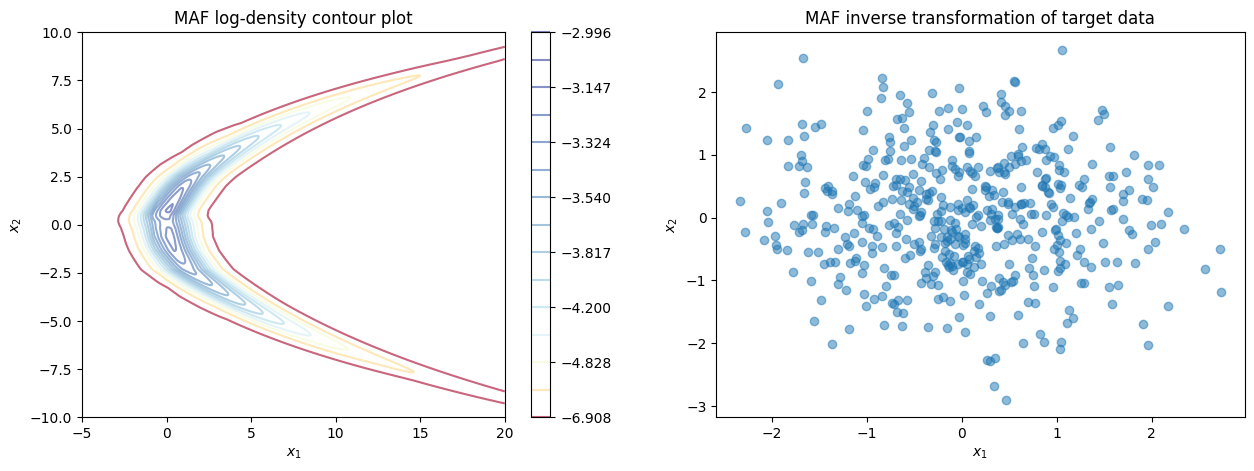

In [119]:
# Make a contour and scatter plot from the target density

X, Y = np.meshgrid(np.linspace(-5, 20, 1000), np.linspace(-10, 10, 500))
X, Y = X.astype(np.float32), Y.astype(np.float32)
Z = maf.log_prob(tf.stack([X, Y], axis=-1))

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
levels = np.log(np.linspace(0.001, 0.05, 15))
plt.contour(X, Y, Z, levels, alpha=0.6, cmap='RdYlBu')
plt.title("MAF log-density contour plot")
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.subplot(1, 2, 2)
plt.title("MAF inverse transformation of target data")
target_samples = target.sample(500)
samples = maf_bijector.inverse(tf.stack([target_samples[1], target_samples[0]], axis=-1))
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

#THIS IS MUCH BETTER